In [1]:
import pandas as pd
import numpy as np

import re
import random

import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import nltk
from pattern.en import lemma

## Load and Clean Data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# replace %20 with '' in keyword. used in place of space [] character
df['keyword'] = df['keyword'].apply(lambda s: s.replace('%20', '') if isinstance(s, str) else s)

#### What fraction of keywords and location are missing?

Only 61 rows have keywords missing. We want to see if there is any preliminary difference we can spot between tweets that are identified as disaster vs those that are not.

On the other hand, nearly 33% (or 2533) tweets have location tag missing. This does not vary between disaster vs non-disaster tweets.

In [4]:
print(df.keyword.isna().sum()) #keywords missing
print(df.location.isna().sum()) #location missing

df.groupby('target')['location'].apply(lambda x: x.isna().sum()/len(x))

61
2533


target
0    0.335790
1    0.328646
Name: location, dtype: float64

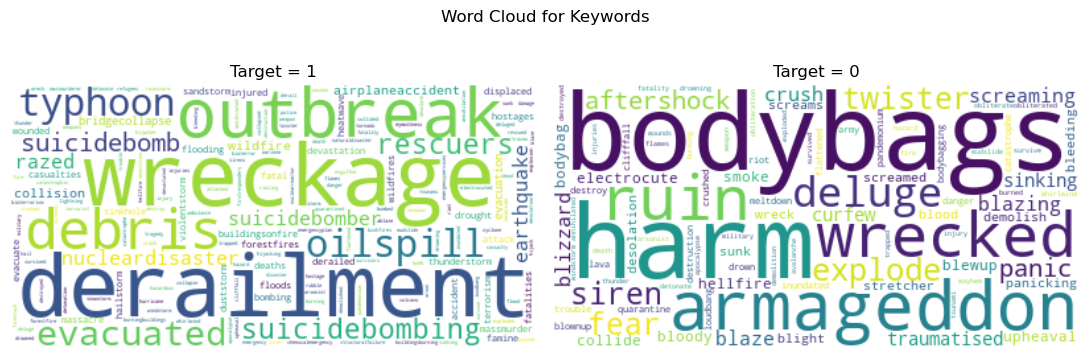

In [5]:
stopwords = set(STOPWORDS)

dict_disaster = df.query('target == 1')['keyword'].value_counts().to_dict()
dict_no_disaster = df.query('target == 0')['keyword'].value_counts().to_dict()

# Generate a word cloud image
wordcloud_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_disaster)
wordcloud_no_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_no_disaster)

# Display the generated image:
# the matplotlib way:
fig, axs = plt.subplots(1, 2, figsize= (11,4));

axs[0].imshow(wordcloud_disaster, interpolation='bilinear');
axs[0].axis("off");
axs[0].set_title("Target = 1");

axs[1].imshow(wordcloud_no_disaster, interpolation='bilinear');
axs[1].axis("off");
axs[1].set_title("Target = 0");

plt.suptitle("Word Cloud for Keywords")
plt.tight_layout();
plt.show();

### Cleaning Data - URL, Punctuations, Emoji, etc

In [6]:
def clean_tweet(tweet):

    # remove punctuation
    reg_punc =re.compile(r'[^\w\s]')
    tweet = reg_punc.sub(r'', tweet)

    # remove html
    reg_html = re.compile(r'<.*?>')
    tweet = reg_html.sub(r'', tweet)

    # remove url
    reg_url = re.compile(r'http\S+')
    tweet = reg_url.sub(r'', tweet)

    # remove numerical values
    reg_num = re.compile(r'[0-9]')
    tweet = reg_num.sub(r'', tweet)

    # remove special characters
    reg_spcl = re.compile('[@_!#$%^&*()<>?/\\|}{~:]')
    tweet = reg_spcl.sub(r'', tweet)

    # remove emoji
    emoji_url = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    tweet = emoji_url.sub(r'', tweet)

    return tweet

df['clean_text'] = df['text'].apply(lambda x: clean_tweet(x))

#### Lemmatization

In [8]:
def lemmatize(tweet):
    lemmatized_tweet = " ".join([word if word.lower()=="this" else lemma(word) for word in tweet.split()])
    return lemmatized_tweet

df['lemmatized_text'] = df['clean_text'].apply(lambda x: lemmatize(x))

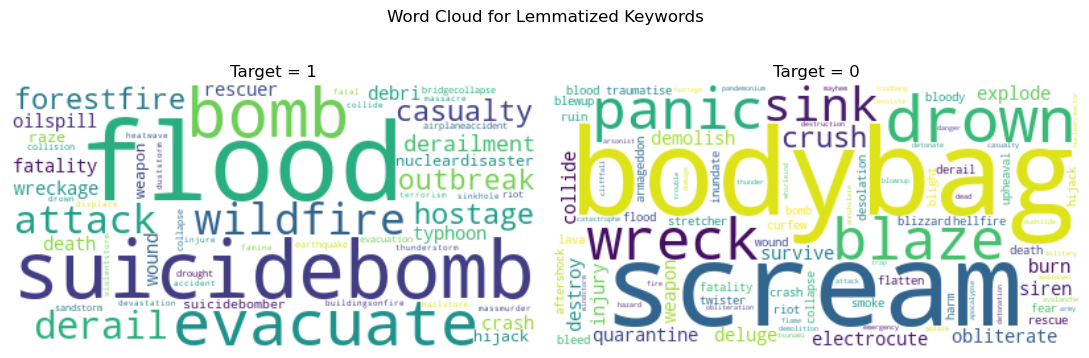

In [9]:
df['lemmatized_keyword'] = df['keyword'].apply(lambda x: lemmatize(x) if isinstance(x,str) else x)

dict_disaster = df.query('target == 1')['lemmatized_keyword'].value_counts().to_dict()
dict_no_disaster = df.query('target == 0')['lemmatized_keyword'].value_counts().to_dict()

# Generate a word cloud image
wordcloud_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_disaster)
wordcloud_no_disaster = WordCloud(stopwords=stopwords, background_color="white").generate_from_frequencies(dict_no_disaster)

# Display the generated image:
# the matplotlib way:
fig, axs = plt.subplots(1, 2, figsize= (11,4));

axs[0].imshow(wordcloud_disaster, interpolation='bilinear');
axs[0].axis("off");
axs[0].set_title("Target = 1");

axs[1].imshow(wordcloud_no_disaster, interpolation='bilinear');
axs[1].axis("off");
axs[1].set_title("Target = 0");

plt.suptitle("Word Cloud for Lemmatized Keywords")
plt.tight_layout();
plt.show();

## Build Models

#### Logistic Regression using Keywords
In the statistical inference portion of the code, we observed that there is some difference between the keywords of tweets that represented disaster vs the ones that didn't. Based on this assumption, we can build a simple logistic regression classifier that uses the keywords of the tweets.

**Advantages**
1. Very easy to implement and understand - the coefficients give us a clear intuition of which words increase the probability of the tweet being about an actual disaster vs not.

**Disadvantages**
1. Limited vocabulary. If there is a keyword in the test/validation dataset that we didnt encounter in the training dataset, the model would not know how to handle it.
2. We are not using any of the information in the actual text of the tweets.
3. In any real world application, we would probably have a dataset comprising just the tweet without any keyword attached to it. Limits the application of this model.

             LR_coef
wreckage    2.627808
derailment  2.627808
debri       2.587786
outbreak    2.381983
typhoon     2.339643
...              ...
blaze      -2.069669
panic      -2.170459
ruin       -2.317637
bodybag    -2.346364
aftershock -2.523712

[177 rows x 1 columns]


,0,1
precision,0.757402,0.704230
recall,0.792968,0.659957


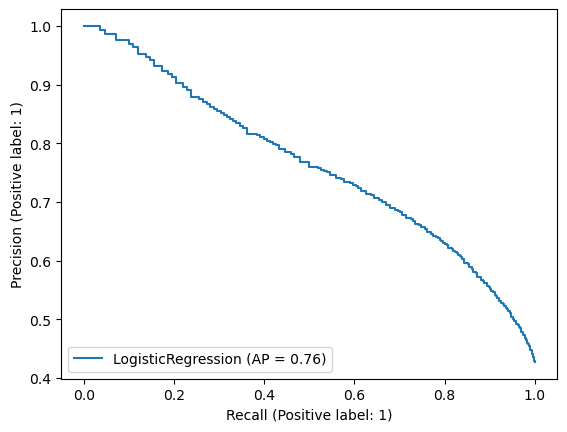

In [10]:
count_vec = CountVectorizer()
X_keyword = count_vec.fit_transform(df['lemmatized_keyword'].dropna())
y_keyword = df.dropna(subset= ['lemmatized_keyword'])['target']

keyword_lreg = LogisticRegression(fit_intercept= False)
keyword_lreg.fit(X_keyword,y_keyword)

print(pd.DataFrame(keyword_lreg.coef_, columns= count_vec.get_feature_names_out(), index= ["LR_coef"])
      .T.sort_values("LR_coef", ascending= False) )

PrecisionRecallDisplay.from_estimator(keyword_lreg, X_keyword, y_keyword)
# ConfusionMatrixDisplay.from_estimator(keyword_lreg, X_keyword, y_keyword)
pd.DataFrame(precision_recall_fscore_support(y_keyword, keyword_lreg.predict(X_keyword)), index= ['precision','recall','f1score','support']).head(2)

#### TF-IDF Vectorization

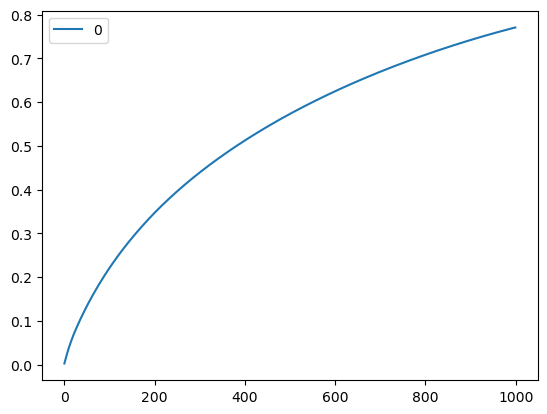

['aa' 'aba' 'aba woman' ... 'zombie apocalypse' 'zone' 'zouma']
(7613, 4849)


In [11]:
corpus = df['lemmatized_text'].tolist()

vectorizer = TfidfVectorizer(ngram_range= (1,3), stop_words= 'english', strip_accents= 'ascii', min_df= 5e-4)
X = vectorizer.fit_transform(corpus)

svd = TruncatedSVD(n_components= 1000)
X_pca = svd.fit_transform(X)

pd.DataFrame(svd.explained_variance_ratio_).cumsum().plot()
plt.show()

print(vectorizer.get_feature_names_out())
print(X.shape)

In [12]:
y_train = df['target']
logreg_model = LogisticRegression(fit_intercept= False)
logreg_model.fit(X_pca, y_train)

knn_model = KNeighborsClassifier(n_neighbors= 5)
knn_model.fit(X_pca, y_train);

tree_model = DecisionTreeClassifier(min_samples_leaf= 2)
tree_model.fit(X_pca, y_train);

,0,1
precision,0.950519,0.987362
recall,0.991018,0.931519


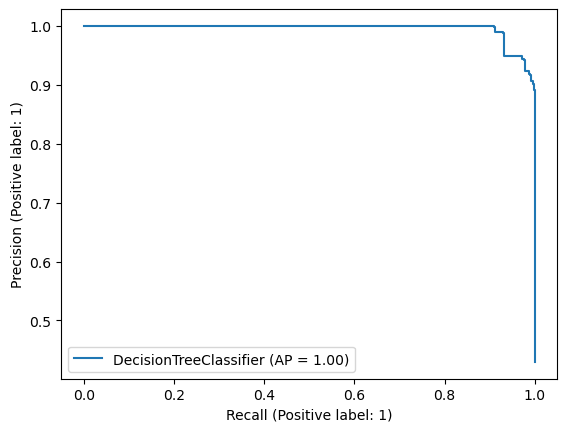

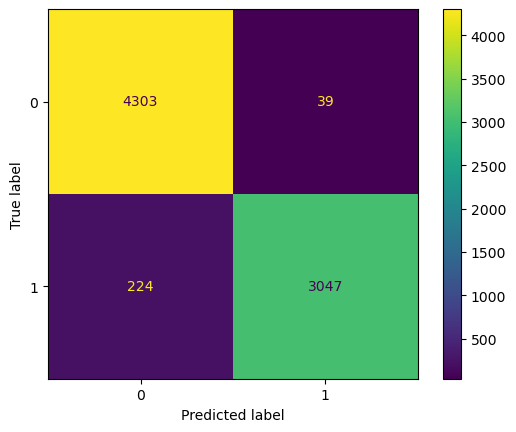

In [13]:
model_slct = tree_model

PrecisionRecallDisplay.from_estimator(model_slct, X_pca, y_train)
ConfusionMatrixDisplay.from_estimator(model_slct, X_pca, y_train)
pd.DataFrame(precision_recall_fscore_support(y_train, model_slct.predict(X_pca)), index= ['precision','recall','f1score','support']).head(2)

,keyword,text,target,tree_predict,logreg_predict,keyword_predict,target_predict
6364,suicidebomb,Pic of 16yr old PKK suicide bomber who detonat...,1,1,1,1,1
1911,crushed,How Empire Avenue crushed my soul http://t.co/...,0,0,0,0,0
6015,screams,* Screams *,0,0,0,0,0
6377,suicidebomb,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1,1,1,1,1
3140,emergency,AlaskaÛªs Prince of Wales #ArchipelagoWolves ...,1,1,1,0,1


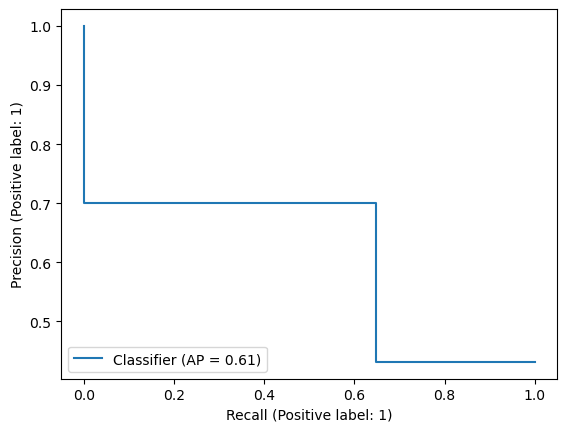

In [14]:
idx_random = random.sample(df.dropna().index.tolist(), 5000)
df_random = df.loc[idx_random, ['keyword','text','target']]

df_random['tree_predict'] = tree_model.predict(X_pca[idx_random, :])
df_random['logreg_predict'] = logreg_model.predict(X_pca[idx_random, :])
df_random['keyword_predict'] = keyword_lreg.predict(count_vec.transform(df.loc[idx_random, 'lemmatized_keyword']))

# overall prediction
df_random['target_predict'] = (df_random[['tree_predict', 'logreg_predict', 'keyword_predict']].sum(axis= 1) >= 2).astype(int)

PrecisionRecallDisplay.from_predictions(df_random.target, df_random.keyword_predict)

df_random.head()

In [16]:
## check a new random tweet
df_test = pd.read_csv("data/test.csv")
df_test['lemmatized_keyword'] = df_test['keyword'].apply(lambda x: lemmatize(x.replace('%20','')) if isinstance(x,str) else x)
test_tweets = df_test['text'].tolist()

test_tweets = [lemmatize(clean_tweet(tt)) for tt in test_tweets]
X_test = svd.transform(vectorizer.transform(test_tweets))

df_test['tree_predict'] = tree_model.predict(X_test)
df_test['logreg_predict'] = logreg_model.predict(X_test)
df_test['knn_predict'] = knn_model.predict(X_test)

# only non NA keywords
non_na_idx = df_test.dropna(subset= ['lemmatized_keyword']).index.tolist()
df_test.loc[non_na_idx, "keyword_predict"] = keyword_lreg.predict(count_vec.transform(df_test.loc[non_na_idx, 'lemmatized_keyword']))

# Overall Predict
df_test['target'] = np.nan
# if tree and logreg prediction the same
df_test.loc[df_test.tree_predict == df_test.logreg_predict, "target"] = df_test.loc[df_test.tree_predict == df_test.logreg_predict, "tree_predict"]
# if not the same consider the max
tmp_idx = df_test.loc[(~df_test.keyword.isna()) & df_test.target.isna()].index
df_test.loc[tmp_idx, "target"] = (df_test.loc[tmp_idx,["logreg_predict", "keyword_predict", "knn_predict"]].sum(axis= 1) > 2).astype(int)
# remaining
df_test.loc[df_test.target.isna(), "target"] = (df_test.loc[df_test.target.isna(),["logreg_predict", "knn_predict"] 
                    ].mul([0.7, 0.3]).sum(axis= 1) >= 0.5).astype(int)

####
# df_test.loc[~df_test.keyword.isna(), "target"] = (df_test.loc[~df_test.keyword.isna(), 
#             ["tree_predict", "logreg_predict", "keyword_predict"]].sum(axis=1) >= 2).astype(int)
# # if keyword is NA, if logreg and tree have same prediction use that
# tmp_idx = df_test.keyword_predict.isna() & (df_test.tree_predict == df_test.logreg_predict)
# df_test.loc[tmp_idx, "target"] = df_test.loc[tmp_idx, "tree_predict"]
# # otherwise use average of logreg, tree and kNN model
# df_test.loc[df_test.target.isna(), "target"] = df_test.loc[df_test.target.isna(), "knn_predict"]

# convert to int
df_test['target'] = df_test['target'].astype(int)

print(df_test.loc[random.sample(df_test.index.tolist(),20)])


         id         keyword             location  \
867    2845         cyclone                  NaN   
3193  10614         wounded          Philippines   
456    1468  body%20bagging                  NaN   
1147   3784     destruction                  NaN   
3161  10493        wildfire                  USA   
893    2951          danger   Brinscall, England   
1451   4815      evacuation                  NaN   
1163   3844        detonate            Amsterdam   
1701   5749  forest%20fires      alberta, canada   
3223  10714           wreck                  NaN   
1251   4115         drought        Windsor ??CT    
1070   3541      derailment                  NaN   
2960   9803         trapped                  NaN   
2452   8193            riot   Wakefield, England   
1595   5394    fire%20truck                  NaN   
1282   4217         drowned        FEMA REGION 2   
1158   3813        detonate        Morioh, Japan   
408    1323          bloody                  NaN   
380    1231 

In [17]:
df_submission = df_test[['id', "target"]]
df_submission.to_csv("data/submission_combined_weighted_models.csv", index= False)

df_test[['id', "tree_predict"]].rename(columns = {'tree_predict':'target'}).to_csv("data/submission_new_tree.csv", index= False)

df_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [19]:
for ii in df_test.head(60).tail(30).index.tolist():
    print("Target: " + str(df_test.loc[ii,'target']))
    print(df_test.loc[ii,"text"])
    print(df_test.loc[ii, ['tree_predict','logreg_predict','knn_predict','keyword_predict']])
    print("Keyword: " + str(df_test.loc[ii,"lemmatized_keyword"]))
    print("-----------------------------------------------------------------")

Target: 0
Just got to love burning your self on a damn curling wand... I swear someone needs to take it away from me cuase I'm just accident prone.
tree_predict         0
logreg_predict       0
knn_predict          0
keyword_predict    1.0
Name: 30, dtype: object
Keyword: accident
-----------------------------------------------------------------
Target: 0
I hate badging shit in accident
tree_predict         0
logreg_predict       1
knn_predict          0
keyword_predict    1.0
Name: 31, dtype: object
Keyword: accident
-----------------------------------------------------------------
Target: 1
#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Camera Vehicle Traffic/Driving History/Accident Camcorder  Large Re... http://t.co/kKFaSJv6Cj
tree_predict         0
logreg_predict       1
knn_predict          1
keyword_predict    1.0
Name: 32, dtype: object
Keyword: accident
-----------------------------------------------------------------
Target: 0
Coincidence Or #Curse? Still #Unresolved Secrets From 

In [ ]:
df_test.loc[(df_test.tree_predict!=df_tst